# Aligning biological sequences using DCAlign

In the following, we will show:
- how to get a seed model, i.e. the DCA parameters as well as the empirical priors, from the seed (Pfam or Rfam);
- the main steps needed to align a sequence to a seed model. 
As an example, we deal with the Pfam family PF00684, PF00035 and Rfam family RF00167


#### 1. Let us activate the notebook:


In [1]:
using DelimitedFiles
using Pkg
Pkg.activate(".")
#Pkg.instantiate()
Pkg.activate("../")
using DCAlign

  Activating project at `~/All_GitHub/DCAlign/notebook`
  Activating project at `~/All_GitHub/DCAlign`


#### 2. Select the family

The variable `q` denotes the number of symbols (21 for protein and 5 for RNA sequences). 

The type of sequence must be specified in the `ctype` variable. 

`fileseed` is a file containing the seed sequences in Stockholm format. When dealing with Pfam or Rfam seeds, these files can be download from the corresponding websites.


In [ ]:
fam = "PF00684"
q = 21;
ctype = :amino
#Pfam seed in Stockholm format
fileseed = "../seeds/" * fam * "_seed.txt"
extra = "";

In [ ]:
fam = "RF00167"
q = 5;
ctype = :nbase
#Rfam seed in Stockholm format
fileseed = "../seeds/" * fam * "_seed.txt"
extra = "";

In [2]:
fam = "PF00035"
q = 21;
ctype = :amino
#Pfam seed in Stockholm format
fileseed = "../seeds/" * fam * "_seed.txt"
extra = "";

#### 3. Get the seed in FASTA and FASTA + insertions format

To get a correct assignment of the insertions and gaps within the Pfam or Rfam seed sequences, we build a Hidden Markov Model (HMM), or a Covariance Model (CM), for the seed. This procedure, together with a HMM (or CM) model (not used) returns an alignment of the seed, stored in the `seedfasta` file. This also determines the length of the DCA model `L`.

To learn the empirical prior over the pointer-difference variables we need to store the aligned sequences, containing insertions as lower-case symbols, in a separate file `seedins`.

In [3]:
out_label = "../seeds/" * fam * "_seed"
if ctype == :amino
    L = align_seed_pfam(fileseed, "../seeds/" * fam * "_seed", extra=extra)
else
    L = align_seed_rfam(fileseed, "../seeds/" * fam * "_seed", extra=extra)
end
seedfasta = out_label * ".fasta"
seedins = out_label * ".ins"

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../seeds/PF00035_seed.txt
# output HMM file:                  /tmp/jl_Xo0BGm/tmp_stk.hmm
# processed alignment resaved to:   /tmp/jl_Xo0BGm/tmp_stk.out
# number of worker threads:         1
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     dsrm                    74   103    66    23.38  0.850 Double-stranded RNA binding motif

# CPU time: 0.02u 0.00s 00:00:00.02 Elapsed: 00:00:00.02


[ Info: Working in /tmp/jl_Xo0BGm
[ Info: ### Computing the HMM and get aligned seed (with and without insertions)
[ Info: L = 66
[ Info: Done!


"../seeds/PF00035_seed.ins"

#### 4. Learn the prior for $\Lambda \left( \Delta n \right)$

We store all the empirical frequencies for positions $i = 1, \cdots, L$, $j > i$, and $\Delta n = n_{j} - n_{i}$ in $\Lambda[i,j,\Delta n]$.

In [4]:
Λ, Mseed, _ = DCAlign.deltan_prior(seedins, L); # i j Δn

Maximum Δn 75


#### 5. Learn the DCA seed model using PlmDCA

Among all possible methods to learn a Direct Coupling Analysis model for the aligned seed, we choose [PlmDCA](https://doi.org/10.1103/PhysRevE.87.012707) for its short running time.

For seed having a few sequences, it is preferable to use a very small regularization parameter, i.e. $\lambda_{J} = \lambda_{h} = 10^{-6}$

In [5]:
using PlmDCA

if ctype == :amino
    if abs(L - Mseed) > 100
        PlmOut = plmdca(seedfasta)
    else
        PlmOut = plmdca(seedfasta, lambdaJ=0.000001, lambdaH=0.000001)
    end
else
    Z, W = DCAlign.get_Z_W(seedfasta, ctype)
    if abs(L - Mseed) > 100
        PlmOut = plmdca(Z, W)
    else
        PlmOut = plmdca(Z, W, lambdaH=0.000001, lambdaJ=0.000001)
    end
end
J = PlmOut.Jtensor
h = PlmOut.htensor;

removing duplicate sequences... done: 74 -> 74
θ = 0.5 threshold = 33.0
M = 74 N = 66 Meff = 74.0
preprocessing took 0.007544007 seconds
site = 1	 pl = 0.0003	 time = 0.0413	exit status = FTOL_REACHED
site = 2	 pl = 0.0002	 time = 0.0362	exit status = FTOL_REACHED
site = 3	 pl = 0.0003	 time = 0.0306	exit status = FTOL_REACHED
site = 4	 pl = 0.0003	 time = 0.0274	exit status = FTOL_REACHED
site = 5	 pl = 0.0001	 time = 0.0346	exit status = FTOL_REACHED
site = 6	 pl = 0.0002	 time = 0.0338	exit status = FTOL_REACHED
site = 7	 pl = 0.0002	 time = 0.0337	exit status = FTOL_REACHED
site = 8	 pl = 0.0003	 time = 0.0329	exit status = FTOL_REACHED
site = 9	 pl = 0.0003	 time = 0.0310	exit status = FTOL_REACHED
site = 10	 pl = 0.0003	 time = 0.0344	exit status = FTOL_REACHED
site = 11	 pl = 0.0003	 time = 0.0338	exit status = FTOL_REACHED
site = 12	 pl = 0.0003	 time = 0.0285	exit status = FTOL_REACHED
site = 13	 pl = 0.0003	 time = 0.0335	exit status = FTOL_REACHED
site = 14	 pl = 0.0003	 tim

#### 6. Load sequences

The function `DCAlign.enveloptoalign` takes as input 
1. a full set of non-aligned sequences alone 
2. a full set of non-aligned sequences together with a known alignment in two formats (a standard insertions-free MSA and a MSA where insertions are added as lower case symbols). 

All files should be written according to the FASTA layout

Ex.

```
PF1_full.fasta 

    >Seq01
    SLSTAQLLQPSGGLQASVISNIVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGRLQEGDEILELNGESMAGLTHQDALQKFK
    QAKKGLLTLTVRTRLTAPHALGGPLSPPLSRS

PF1_align.fasta

    >Seq01/22-104
    -IVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGLQEGDEILELNGESMAGLTHQDALQKFKQAKKLLTLTVR

PF1_ins.fasta

    >Seq01/22-104
    -IVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGrLQEGDEILELNGESMAGLTHQDALQKFKQAKKgLLTLTVR
```

Only for RNA, the names of full-length sequences must contain the position of the hit (in agreement with the standard Rfam format).

You must also specify in `ctype` the type of variables (amino-acids or nucleic bases) and, when the aligned sequences are added as input, the cut-off size `delta` of the full length sequences (the final length will be  `delta_ + _L_ + _delta`)

Usage
1. >seq = DCAlign.enveloptoalign("PF1_full.fasta", ctype = :amino)
2. >seq = DCAlign.enveloptoalign("PF1_full.fasta", "PF1_align.fasta", "PF1_ins.fasta", delta = 20, ctype = :amino)

In the fist case `seq` is a dictionary whereas in the last case it contains for all sequences in $i = 1,\cdots,M$ using the following format:
    
    seq[i][1] : name
    seq[i][2] : full length sequence
    seq[i][3] : aligned sequence
    seq[i][4] : aligned sequence with insertions


In [9]:
delta = 20
al = DCAlign.enveloptoalign("../families/" * fam * "/" * fam * "_full_length_sequences.fasta",
    #"../families/" * fam * "/" * fam * "_full.fasta",
    #"../families/" * fam * "/" * fam * "_full.ins",
    "../families/" * fam * "/" * fam * "_alignment.fasta",
    "../families/" * fam * "/" * fam * "_alignment.ins",
    delta=delta, ctype=ctype
)
M = length(al)
println("Tot. number of sequences ", M)
idx0 = rand(1:M)
println("Consider this sequence: ")
(aux, garb) = split(al[idx0][1], "/")
seqsol = al[idx0][3];
seqins = al[idx0][4];
seq = Seq(seqsol, al[idx0][2], ctype)
N = length(al[idx0][2])
println(al[idx0][1])
println("Full length: ")
println(al[idx0][2])
println("Aligned by HMMER (without and with insertions): ")
println(seqsol)
println(seqins)


Tot. number of sequences 33270
Consider this sequence: 
M4E9R7_BRARP/68-173
Full length: 
LSSRVPSKSLTAKILDETGIYKNLLQETAHRAGLDLPMYTSVRSGSYHFPAFSCTVELAGMSFTGESAKTKKQAEKNAAIAAWSSLKKMASLDSMGGKENGEEKEQ
Aligned by HMMER (without and with insertions): 
YKNLLQETAHRAGLDLPMYTSVRSGSYHFPAFSCTVELAGMSFTGESAKTKKQAEKNAAIAAWSSL
YKNLLQETAHRAGLDLPMYTSVRSGSYHFPAFSCTVELAGMSFTGESAKTKKQAEKNAAIAAWSSL


#### 7. Run DCAlign

Run the approximate message-passing algorithm coupled with the annealing scheme. In particular, each $\Delta t$ iterations, $\beta$ is updated as $\beta  += \Delta\beta$.

Convergence is reached when:
- The approximate marginals $P_{i}\left(x,n\right)$ for $i = 1, \cdots,L$ are sufficiently concentrated, i.e. $\min_{i} \max_{x,n} P_{i} \left(x,n\right) < thP$. A reasonable value for $thP$ is 0.30;
- The assignment of the variables gives a properly ordered sequence.

The aligned sequence is compared to a test one by using their Hamming distance and their energies. The latters only consider the Potts energy of the DCA model associated with the seed sequences.

In [10]:
damp = 0.0
seed = 0
pcount = 1.0 / Mseed

@time _, _, res, _ = DCAlign.palign(seq, J, h, Λ, ctype,
    nprint=100, maxiter=1000, seed=seed, thP=0.30, Δβ=0.05,
    damp=damp, verbose=true, pcount=pcount);


marg = deepcopy(res.pbf.P)

P = copy(res.pbf.P)
out = DCAlign.decodeposterior(P, res.seq.strseq, thP=res.alg.thP);
seqpa = out.seq # aligned seq 
seqpo = out.seqins # aligned seq with insertions
sat = DCAlign.check_assignment(P, true, N)

if sat == false
    (seqpa, P) = DCAlign.decimate_post(res, false)
    out = DCAlign.decodeposterior(P, res.seq.strseq, thP=res.alg.thP)
    seqpo = out.seqins
    println("Nucleation sol (a): ", out.seq)
    println("Nucleation sol (ins): ", out.seqins)
    println("(Potts) energy nucl sol: ", DCAlign.compute_potts_en(J, h, out.seq, L, ctype))
end

Ngap, Nins, Nb = DCAlign.count_gaps_ins(out.seqins)
hdist, Gapp, Gapm, Sm = DCAlign.hammingdist(out.seq, seqsol)
println("test           ", seqsol)
println("dcalign.seq    ", out.seq)
println("score          ", out.score)
println("Hamming distance (dcalign, test) = ", hdist)

en = DCAlign.compute_potts_en(J, h, out.seq, L, ctype)
ensol = DCAlign.compute_potts_en(J, h, seqsol, L, ctype)

seq_c = seqpa
println("(Potts) energy of the sequence aligned by DCAlign ", en)
println("(Potts) energy of the compared sequence ", ensol)
flush(stdout)

Run DCAlign for RNA or protein alignment
L = 66: length of the Potts model
N = 106: length of the sequence A to be aligned
A: LSSRVPSKSLTAKILDETGIYKNLLQETAHRAGLDLPMYTSVRSGSYHFPAFSCTVELAGMSFTGESAKTKKQAEKNAAIAAWSSLKKMASLDSMGGKENGEEKEQ
it = 7 -- en = -477.44 sat = 1 min(max P) = 6.17e-01 β = 1.00 (ΔP,ΔB,ΔF) = 2.95e-01 3.70e-01 2.07e-01 
  0.715813 seconds (7.91 k allocations: 31.554 MiB)
Let us check the assignment...
The subsequence satisfies the constraints
test           YKNLLQETAHRAGLDLPMYTSVRSGSYHFPAFSCTVELAGMSFTGESAKTKKQAEKNAAIAAWSSL
dcalign.seq    YKNLLQETAHRAGLDLPMYTSVRSGSYHFPAFSCTVELAGMSF-TGESATKKQAEKNAAIAAWSSL
score          999999999999999999999999999999999999999999967777699999999999999999
Hamming distance (dcalign, test) = 6
(Potts) energy of the sequence aligned by DCAlign -477.4431684929242
(Potts) energy of the compared sequence -405.96405527033704


#### 8. Marginal probabilities at convergence

Let us plot the (approximate) marginal probability at convergence.

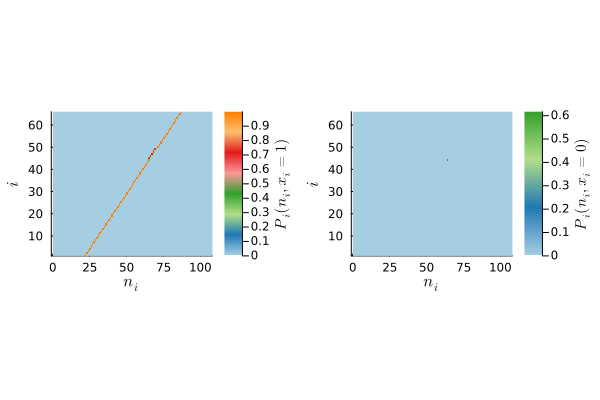

In [11]:

using Plots
using ColorSchemes
using LaTeXStrings
N = length(seq.intseq)

M = zeros(L, N + 2)

for i = 1:L
    m = marg[i]
    for n = 0:N+1
        M[i, n+1] = m[1, n]
    end
end


col = cgrad(:Paired_8)
m1 = minimum(M)
m2 = maximum(M)

p1 = heatmap(M, c=col, aspect_ratio=1.5, xlims=(-1, N + 2), ylims=(1, L), colorbar_title=L"P_{i}(n_{i}, x_{i} = 1)")
M = zeros(L, N + 2)
for i = 1:L
    m = marg[i]
    for n = 0:N+1
        M[i, n+1] = m[0, n]
    end
end
m2 = maximum(M)
idx = floor(Int, m2 * size(col)[1])
p2 = heatmap(M, c=col[1:idx], colorbar_title=L"P_{i}(n_{i}, x_{i} = 0)", aspect_ratio=1.5, xlims=(-1, N + 2), ylims=(1, L))
plot(p1, p2, xlabel=L"n_{i}", ylabel=L"i")

